In [1]:
import math
import os
import torch
import logging
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import multiprocessing
from os.path import join
from datetime import datetime
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
import datasets_ws
import math
import torch
import torchvision
import faiss
import test
import logging
import numpy as np
from tqdm.notebook import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, SubsetRandomSampler
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

AttributeError: module 'faiss' has no attribute 'StandardGpuResources'

In [2]:
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
triplets_ds = datasets_ws.TripletsDataset("D:/datasets/", 'pitts30k/', "train", negs_num_per_query = 10)
val_ds = datasets_ws.BaseDataset("D:/datasets/", 'pitts30k/', "val")
test_ds = datasets_ws.BaseDataset("D:/datasets/", 'pitts30k/', "test")

In [6]:
class NetVLAD(nn.Module):
    """NetVLAD layer implementation"""

    def __init__(self, clusters_num=64, dim=128, normalize_input=True, work_with_tokens=False):
        """
        Args:
            clusters_num : int
                The number of clusters
            dim : int
                Dimension of descriptors
            alpha : float
                Parameter of initialization. Larger value is harder assignment.
            normalize_input : bool
                If true, descriptor-wise L2 normalization is applied to input.
        """
        super().__init__()
        self.clusters_num = clusters_num
        self.dim = dim
        self.alpha = 0
        self.normalize_input = normalize_input
        self.work_with_tokens = work_with_tokens
        if work_with_tokens:
            self.conv = nn.Conv1d(dim, clusters_num, kernel_size=1, bias=False)
        else:
            self.conv = nn.Conv2d(dim, clusters_num, kernel_size=(1, 1), bias=False)
        self.centroids = nn.Parameter(torch.rand(clusters_num, dim))

    def init_params(self, centroids, descriptors):
        centroids_assign = centroids / np.linalg.norm(centroids, axis=1, keepdims=True)
        dots = np.dot(centroids_assign, descriptors.T)
        dots.sort(0)
        dots = dots[::-1, :]

        self.alpha = (-np.log(0.01) / np.mean(dots[0,:] - dots[1,:])).item()
        self.centroids = nn.Parameter(torch.from_numpy(centroids))
        if self.work_with_tokens:
            self.conv.weight = nn.Parameter(torch.from_numpy(self.alpha * centroids_assign).unsqueeze(2))
        else:
            self.conv.weight = nn.Parameter(torch.from_numpy(self.alpha*centroids_assign).unsqueeze(2).unsqueeze(3))
        self.conv.bias = None

    def forward(self, x):
        if self.work_with_tokens:
            x = x.permute(0, 2, 1)
            N, D, _ = x.shape[:]
        else:
            N, D, H, W = x.shape[:]
        if self.normalize_input:
            x = F.normalize(x, p=2, dim=1)  # Across descriptor dim
        x_flatten = x.view(N, D, -1)
        # print(f': x.shape : {x.size()}')
        # print(f'conv(x) size = {self.conv(x).size()}')
        soft_assign = self.conv(x).view(N, self.clusters_num, -1)
        soft_assign = F.softmax(soft_assign, dim=1)
        vlad = torch.zeros([N, self.clusters_num, D], dtype=x_flatten.dtype, device=x_flatten.device)
        for D in range(self.clusters_num):  # Slower than non-looped, but lower memory usage
            residual = x_flatten.unsqueeze(0).permute(1, 0, 2, 3) - \
                    self.centroids[D:D+1, :].expand(x_flatten.size(-1), -1, -1).permute(1, 2, 0).unsqueeze(0)
            residual = residual * soft_assign[:,D:D+1,:].unsqueeze(2)
            vlad[:,D:D+1,:] = residual.sum(dim=-1)
        vlad = F.normalize(vlad, p=2, dim=2)  # intra-normalization
        vlad = vlad.view(N, -1)  # Flatten
        vlad = F.normalize(vlad, p=2, dim=1)  # L2 normalize
        return vlad

    def initialize_netvlad_layer(self, cluster_ds, backbone):
        descriptors_num = 100000
        descs_num_per_image = 100
        images_num = math.ceil(descriptors_num / descs_num_per_image)
        random_sampler = SubsetRandomSampler(np.random.choice(len(cluster_ds), images_num, replace=False))
        random_dl = DataLoader(dataset=cluster_ds, 
                                batch_size=16, sampler=random_sampler)
        with torch.no_grad():
            backbone = backbone.eval()
            # logging.debug("Extracting features to initialize NetVLAD layer")
            descriptors = np.zeros(shape=(descriptors_num, features_dim), dtype=np.float32)
            for iteration, (inputs, _) in enumerate(tqdm(random_dl, ncols=100)):
                inputs = inputs.to("cuda")
                outputs = backbone(inputs)
                # print(f'outputs: {outputs.size()}')
                norm_outputs = F.normalize(outputs, p=2, dim=1)
                # print(f'norm_outputs: {norm_outputs.size()}')
                # print(f'shape [0] : {norm_outputs.shape[0]}')
                image_descriptors = norm_outputs.view(norm_outputs.shape[0], features_dim, -1).permute(0, 2, 1)
                image_descriptors = image_descriptors.cpu().numpy()
                batchix = iteration * 16 * descs_num_per_image
                # print(f'image_descriptors : {image_descriptors.shape}')
                for ix in range(image_descriptors.shape[0]):
                    sample = np.random.choice(image_descriptors.shape[1], descs_num_per_image, replace=False)
                    startix = batchix + ix * descs_num_per_image
                    descriptors[startix:startix + descs_num_per_image, :] = image_descriptors[ix, sample, :]
        kmeans = faiss.Kmeans(features_dim, self.clusters_num, niter=100, verbose=False)
        kmeans.train(descriptors)
#         logging.debug(f"NetVLAD centroids shape: {kmeans.centroids.shape}")
        self.init_params(kmeans.centroids, descriptors)
        self = self.to("cuda")

In [7]:
def get_output_channels_dim(model):
    """Return the number of channels in the output of a model."""
    return model(torch.ones([1, 3, 224, 224])).shape[1]

In [8]:
def get_backbone(model_name):
    # The aggregation layer works differently based on the type of architecture
    if model_name.startswith("resnet"):
        if 1 == 2:
            backbone = get_pretrained_model(args)
        elif model_name.startswith("resnet18"):
            backbone = torchvision.models.resnet18(pretrained=True)
        elif model_name.startswith("resnet50"):
            backbone = torchvision.models.resnet50(pretrained=True)
        elif model_name.startswith("resnet101"):
            backbone = torchvision.models.resnet101(pretrained=True)
        for name, child in backbone.named_children():
            # Freeze layers before conv_3
            if name == "layer3":
                break
            for params in child.parameters():
                params.requires_grad = False
        if model_name.endswith("conv4"):
            # logging.debug(f"Train only conv4_x of the resnet{args.backbone.split('conv')[0]} (remove conv5_x), freeze the previous ones")
            layers = list(backbone.children())[:-3]
        elif model_name.endswith("conv5"):
            # logging.debug(f"Train only conv4_x and conv5_x of the resnet{args.backbone.split('conv')[0]}, freeze the previous ones")
            layers = list(backbone.children())[:-2]
    elif model_name == "vgg16":
        if 1 == 2:
            backbone = get_pretrained_model(args)
        else:
            backbone = torchvision.models.vgg16(pretrained=True)
        layers = list(backbone.features.children())[:-2]
        for l in layers[:-5]:
            for p in l.parameters(): p.requires_grad = False
        # logging.debug("Train last layers of the vgg16, freeze the previous ones")
    elif model_name == "alexnet":
        backbone = torchvision.models.alexnet(pretrained=True)
        layers = list(backbone.features.children())[:-2]
        for l in layers[:5]:
            for p in l.parameters(): p.requires_grad = False
        # logging.debug("Train last layers of the alexnet, freeze the previous ones")
    elif model_name.startswith("cct"):
        if model_name.startswith("cct384"):
            backbone = cct_14_7x2_384(pretrained=True, progress=True, aggregation=args.aggregation)
        if 1 == 2:
            # logging.debug(f"Truncate CCT at transformers encoder {args.trunc_te}")
            backbone.classifier.blocks = torch.nn.ModuleList(backbone.classifier.blocks[:args.trunc_te].children())
        if 1 == 2:
            # logging.debug(f"Freeze all the layers up to tranformer encoder {args.freeze_te}")
            for p in backbone.parameters():
                p.requires_grad = False
            for name, child in backbone.classifier.blocks.named_children():
                if int(name) > args.freeze_te:
                    for params in child.parameters():
                        params.requires_grad = True
        features_dim = 384
        return backbone
    elif model_name.startswith("vit"):
        # assert args.resize[0] in [224, 384], f'Image size for ViT must be either 224 or 384, but it\'s {args.resize[0]}'
        if 1 == 2:
            backbone = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        elif 1 == 384:
            backbone = ViTModel.from_pretrained('google/vit-base-patch16-384')

        if 1 == 2:
            # logging.debug(f"Truncate ViT at transformers encoder {args.trunc_te}")
            backbone.encoder.layer = backbone.encoder.layer[:args.trunc_te]
        if 1 == 2:
            logging.debug(f"Freeze all the layers up to tranformer encoder {args.freeze_te+1}")
            for p in backbone.parameters():
                p.requires_grad = False
            for name, child in backbone.encoder.layer.named_children():
                if 1 == 2:
                    for params in child.parameters():
                        params.requires_grad = True
        backbone = VitWrapper(backbone, args.aggregation)
        
        features_dim = 768
        return backbone

    backbone = torch.nn.Sequential(*layers)
    features_dim = get_output_channels_dim(backbone)  # Dinamically obtain number of channels in output
    # print(features_dim)
    return backbone

In [9]:
features_dim = 256

In [10]:
class GeoLocalizationNet(nn.Module):
    """The used networks are composed of a backbone and an aggregation layer.
    """
    def __init__(self):
        super().__init__()
        self.backbone = get_backbone('resnet18conv4')
        # self.arch_name = 
        self.aggregation = NetVLAD(clusters_num=64, dim=features_dim,
                                   work_with_tokens=False)
    def forward(self, x):
        # print(f'size in forward before backbone: {x.size()}')
        x = self.backbone(x)
        # print(f'size in forward after backbone: {x.size()}')
        x = self.aggregation(x)
        return x

In [11]:
model = GeoLocalizationNet()
model = model.to("cuda")

In [12]:
# get_output_channels_dim(model)

In [13]:
triplets_ds.is_inference = True
model.aggregation.initialize_netvlad_layer(triplets_ds, model.backbone)

  0%|                                                                        | 0/63 [00:00<?, ?it/s]

In [14]:
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4, momentum=0.9, weight_decay=0.001)
criterion_triplet = nn.TripletMarginLoss(margin=0.1, p=2, reduction="sum")

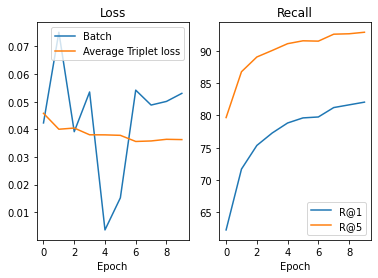

In [15]:
epochs = 10


batch_losses = []
triplet_losses = []
rec1 = []
rec5 = []

best_r5 = start_epoch_num = not_improved_num = 0


for epoch in tqdm(range(epochs), desc = "Epochs"):
    
    epoch_losses = np.zeros((0, 1), dtype=np.float32)
    
    
    num_loops = 1
    for loop in range(num_loops):
        print(f'loop : {loop+1}')
        triplets_ds.is_inference = True
        triplets_ds.compute_triplets(model)
        triplets_ds.is_inference = False
        
        triplets_dl = DataLoader(dataset=triplets_ds,
                                 batch_size=4,
                                 collate_fn=datasets_ws.collate_fn,
                                 pin_memory=("cuda" == "cuda"),
                                 drop_last=True)
        
        model = model.train()
        
        for images, triplets_local_indexes, _ in tqdm(triplets_dl, desc = 'Batch processing'):
            
            # Flip all triplets or none
            # if args.horizontal_flip:
            #     images = transforms.RandomHorizontalFlip()(images)
            
            # Compute features of all images (images contains queries, positives and negatives)
            features = model(images.to("cuda"))
            loss_triplet = 0
            
            # if args.criterion == "triplet":
            triplets_local_indexes = torch.transpose(
                triplets_local_indexes.view(4, 10, 3), 1, 0)
            for triplets in triplets_local_indexes:
                queries_indexes, positives_indexes, negatives_indexes = triplets.T
                loss_triplet += criterion_triplet(features[queries_indexes],
                                                  features[positives_indexes],
                                                  features[negatives_indexes])
            # elif args.criterion == 'sare_joint':
            #     # sare_joint needs to receive all the negatives at once
            #     triplet_index_batch = triplets_local_indexes.view(args.train_batch_size, 10, 3)
            #     for batch_triplet_index in triplet_index_batch:
            #         q = features[batch_triplet_index[0, 0]].unsqueeze(0)  # obtain query as tensor of shape 1xn_features
            #         p = features[batch_triplet_index[0, 1]].unsqueeze(0)  # obtain positive as tensor of shape 1xn_features
            #         n = features[batch_triplet_index[:, 2]]               # obtain negatives as tensor of shape 10xn_features
            #         loss_triplet += criterion_triplet(q, p, n)
            # elif args.criterion == "sare_ind":
            #     for triplet in triplets_local_indexes:
            #         # triplet is a 1-D tensor with the 3 scalars indexes of the triplet
            #         q_i, p_i, n_i = triplet
            #         loss_triplet += criterion_triplet(features[q_i:q_i+1], features[p_i:p_i+1], features[n_i:n_i+1])
            
            del features
            loss_triplet /= (4 * 10)
            
            optimizer.zero_grad()
            loss_triplet.backward()
            optimizer.step()
            
            # Keep track of all losses by appending them to epoch_losses
            batch_loss = loss_triplet.item()
            epoch_losses = np.append(epoch_losses, batch_loss)
            
            del loss_triplet
        triplet_losses.append(epoch_losses.mean())
        batch_losses.append(batch_loss)
        # print(f"Batch loss: {batch_loss:.4f}")
        # print(f"Average triplet loss: {epoch_losses.mean():.4f}")
        
        
            
    recalls, recalls_str = test.test(val_ds, model)
    rec1.append(recalls[0])
    rec5.append(recalls[1])
    clear_output()
    fig, (ax0, ax1) = plt.subplots(1, 2)
    ax0.set_title('Loss')
    ax0.plot(batch_losses, label = 'Batch')
    ax0.plot(triplet_losses, label = 'Average Triplet loss')
    ax0.set_xlabel('Epoch')
    ax0.legend()
    ax1.set_title('Recall')
    ax1.plot(rec1, label = 'R@1')
    ax1.plot(rec5, label = 'R@5')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    plt.legend()
    plt.show()
    is_best = recalls[1] > best_r5
    # print(f"Recalls on val set {val_ds}: {recalls_str}")

In [18]:
recalls, recalls_str = test.test( test_ds, model, test_method="hard_resize")

test 1:   0%|          | 0/625 [00:00<?, ?it/s]

test 2:   0%|          | 0/426 [00:00<?, ?it/s]

Query index:   0%|          | 0/6816 [00:00<?, ?it/s]

In [19]:
print(recalls_str)

R@1: 81.4, R@5: 90.6


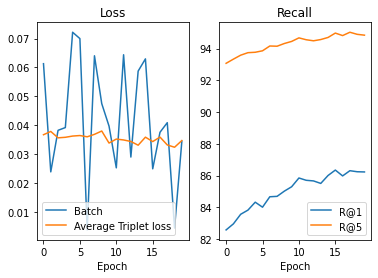

In [20]:
epochs = 20


batch_losses = []
triplet_losses = []
rec1 = []
rec5 = []

best_r5 = start_epoch_num = not_improved_num = 0


for epoch in tqdm(range(epochs), desc = "Epochs"):
    
    epoch_losses = np.zeros((0, 1), dtype=np.float32)
    
    
    num_loops = 1
    for loop in range(num_loops):
        print(f'loop : {loop+1}')
        triplets_ds.is_inference = True
        triplets_ds.compute_triplets(model)
        triplets_ds.is_inference = False
        
        triplets_dl = DataLoader(dataset=triplets_ds,
                                 batch_size=4,
                                 collate_fn=datasets_ws.collate_fn,
                                 pin_memory=("cuda" == "cuda"),
                                 drop_last=True)
        
        model = model.train()
        
        for images, triplets_local_indexes, _ in tqdm(triplets_dl, desc = 'Batch processing'):
            
            # Flip all triplets or none
            # if args.horizontal_flip:
            #     images = transforms.RandomHorizontalFlip()(images)
            
            # Compute features of all images (images contains queries, positives and negatives)
            features = model(images.to("cuda"))
            loss_triplet = 0
            
            # if args.criterion == "triplet":
            triplets_local_indexes = torch.transpose(
                triplets_local_indexes.view(4, 10, 3), 1, 0)
            for triplets in triplets_local_indexes:
                queries_indexes, positives_indexes, negatives_indexes = triplets.T
                loss_triplet += criterion_triplet(features[queries_indexes],
                                                  features[positives_indexes],
                                                  features[negatives_indexes])
            # elif args.criterion == 'sare_joint':
            #     # sare_joint needs to receive all the negatives at once
            #     triplet_index_batch = triplets_local_indexes.view(args.train_batch_size, 10, 3)
            #     for batch_triplet_index in triplet_index_batch:
            #         q = features[batch_triplet_index[0, 0]].unsqueeze(0)  # obtain query as tensor of shape 1xn_features
            #         p = features[batch_triplet_index[0, 1]].unsqueeze(0)  # obtain positive as tensor of shape 1xn_features
            #         n = features[batch_triplet_index[:, 2]]               # obtain negatives as tensor of shape 10xn_features
            #         loss_triplet += criterion_triplet(q, p, n)
            # elif args.criterion == "sare_ind":
            #     for triplet in triplets_local_indexes:
            #         # triplet is a 1-D tensor with the 3 scalars indexes of the triplet
            #         q_i, p_i, n_i = triplet
            #         loss_triplet += criterion_triplet(features[q_i:q_i+1], features[p_i:p_i+1], features[n_i:n_i+1])
            
            del features
            loss_triplet /= (4 * 10)
            
            optimizer.zero_grad()
            loss_triplet.backward()
            optimizer.step()
            
            # Keep track of all losses by appending them to epoch_losses
            batch_loss = loss_triplet.item()
            epoch_losses = np.append(epoch_losses, batch_loss)
            
            del loss_triplet
        triplet_losses.append(epoch_losses.mean())
        batch_losses.append(batch_loss)
        # print(f"Batch loss: {batch_loss:.4f}")
        # print(f"Average triplet loss: {epoch_losses.mean():.4f}")
        
        
            
    recalls, recalls_str = test.test(val_ds, model)
    rec1.append(recalls[0])
    rec5.append(recalls[1])
    clear_output()
    fig, (ax0, ax1) = plt.subplots(1, 2)
    ax0.set_title('Loss')
    ax0.plot(batch_losses, label = 'Batch')
    ax0.plot(triplet_losses, label = 'Average Triplet loss')
    ax0.set_xlabel('Epoch')
    ax0.legend()
    ax1.set_title('Recall')
    ax1.plot(rec1, label = 'R@1')
    ax1.plot(rec5, label = 'R@5')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    plt.legend()
    plt.show()
    is_best = recalls[1] > best_r5
    # print(f"Recalls on val set {val_ds}: {recalls_str}")

In [21]:
recalls, recalls_str = test.test( test_ds, model, test_method="hard_resize")

test 1:   0%|          | 0/625 [00:00<?, ?it/s]

test 2:   0%|          | 0/426 [00:00<?, ?it/s]

Query index:   0%|          | 0/6816 [00:00<?, ?it/s]

In [22]:
print(recalls_str)

R@1: 84.1, R@5: 92.1
